# PM 5 Task H Eigenmode Truncation


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
import time

# Import sonar simulation functions
from getParam_Sonar import getParam_Sonar
from eval_f_Sonar import eval_f_Sonar
from eval_g_Sonar import eval_g_Sonar
from eval_u_Sonar import eval_u_Sonar_20, eval_u_Sonar_20_const
from simpleLeapFrog import LeapfrogSolver

In [2]:
FAST_TEST = True  # Set to False for full PM5 run

print(f"Mode: {'FAST TEST (20 Hz)' if FAST_TEST else 'FULL RUN (3000 Hz)'}")

Mode: FAST TEST (20 Hz)


## Full Order Model

In [3]:
if FAST_TEST:
    # 20 Hz in coarse domain 
    Lx, Lz = 8e3, 500      
    Nx, Nz = 301, 21  
    f0 = 20               
    eval_u = eval_u_Sonar_20      
else:
    # 3000 Hz in fine domain 
    #Lx, Lz = 1000, 1000   
    #Nx, Nz = 101, 101       
    #f0 = 20                 
    #eval_u = eval_u_Sonar_coarse  
    #t_sim = 1    

    Lx, Lz = 10, 10   
    Nx, Nz = 51, 51       
    f0 = 3000                 
    eval_u = eval_u_Sonar_20
    t_sim = 0.005         

N = Nx * Nz
n = 2 * N

print(f"Domain: {Lx}m x {Lz}m")
print(f"Grid: {Nx} x {Nz} = {N:,} spatial points")
print(f"State dimension: 2N = {n:,}")

# Get parameters (this builds A and B)
p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(
    Nx, Nz, Lx, Lz, UseSparseMatrices=True, BC=True
)

t_sim = t_stop 

# Extract system matrices
A = p['A']
B = p['B']

print(f"\nGrid spacing: dx = {p['dx']:.4f}m, dz = {p['dz']:.4f}m")
print(f"Sound speed: c = {p['c']} m/s")
print(f"Max stable dt: {max_dt_FE:.2e}s")

# Wavelength check
wavelength = p['c'] / f0
print(f"\nAt f₀ = {f0} Hz:")
print(f"  Wavelength: λ = {wavelength:.2f}m")
print(f"  Points per wavelength: {wavelength/p['dx']:.0f}")
print(f"  Domain coverage: {Lx/wavelength:.1f}λ × {Lz/wavelength:.1f}λ")


Domain: 8000.0m x 500m
Grid: 301 x 21 = 6,321 spatial points
State dimension: 2N = 12,642

Grid spacing: dx = 26.6667m, dz = 25.0000m
Sound speed: c = 1500.0 m/s
Max stable dt: 5.89e-03s

At f₀ = 20 Hz:
  Wavelength: λ = 75.00m
  Points per wavelength: 3
  Domain coverage: 106.7λ × 6.7λ


### Input function

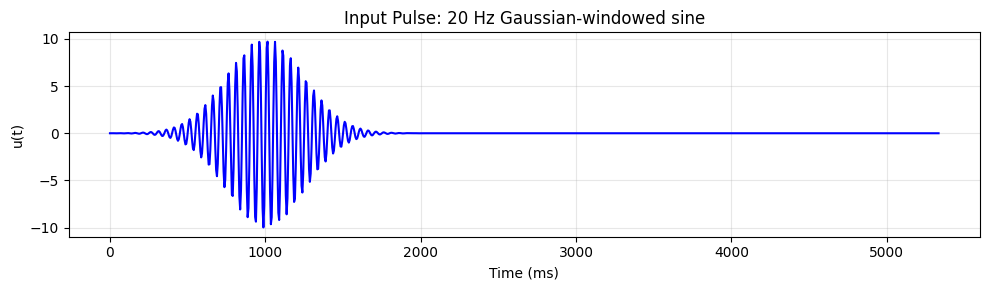

In [4]:
# Scale by cell area (same as PM1)
def eval_u_scaled(t):
    return (p['dx'] * p['dz']) * eval_u(t)

# Visualize pulse
t_test = np.linspace(0, t_sim, 1000)   
u_test = [eval_u(t) for t in t_test]

plt.figure(figsize=(10, 3))
plt.plot(t_test * 1000, u_test, 'b-', linewidth=1.5)
plt.xlabel('Time (ms)')
plt.ylabel('u(t)')
plt.title(f'Input Pulse: {f0} Hz Gaussian-windowed sine')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

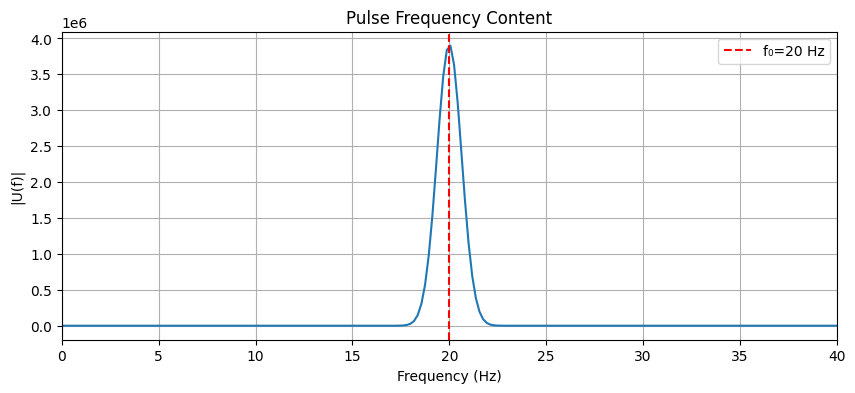

Peak frequency: 20.1 Hz


In [5]:
# FFT of pulse
t_test = np.linspace(0, t_sim, 10000)
u_test = np.array([eval_u_scaled(t) for t in t_test])

from scipy.fft import fft, fftfreq
U_fft = np.abs(fft(u_test))
freqs_fft = fftfreq(len(t_test), t_test[1] - t_test[0])

plt.figure(figsize=(10, 4))
plt.plot(freqs_fft[:len(freqs_fft)//2], U_fft[:len(U_fft)//2])
plt.axvline(x=f0, color='r', linestyle='--', label=f'f₀={f0} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|U(f)|')
plt.title('Pulse Frequency Content')
plt.xlim(0, 2*f0)
plt.legend()
plt.grid(True)
plt.show()

# Where is the energy?
peak_freq = freqs_fft[np.argmax(U_fft[:len(U_fft)//2])]
print(f"Peak frequency: {peak_freq:.1f} Hz")

### Output matrix

In [6]:
# Use hydrophones from getParam_Sonar
n_phones = p['hydrophones']['n_phones']
h_z = p['hydrophones']['z_pos']
h_x_indices = p['hydrophones']['x_indices']

# C matrix selects pressure at hydrophone locations
C = np.zeros((n_phones, n))
for i, hx in enumerate(h_x_indices):
    idx = hx * Nz + h_z
    C[i, idx] = 1.0

print(f"Hydrophones: {n_phones} receivers")
for i, hx in enumerate(h_x_indices):
    print(f"  H{i+1}: x = {hx * p['dx']:.0f}m")

Hydrophones: 5 receivers
  H1: x = 987m
  H2: x = 2480m
  H3: x = 4000m
  H4: x = 5520m
  H5: x = 7040m


## Compute all eigenmodes
Uniform damping so real part is the same for all modes (each mode decays at the same rate)

In [7]:
t0 = time.perf_counter()

if FAST_TEST:
    # SMALL GRID: Dense eigensolve (all modes)
    print("Computing ALL eigenvalues (dense)...")
    A_dense = A.toarray()
    
    eigenvalues, V = np.linalg.eig(A_dense)
    k = len(eigenvalues)
    
    # Compute exact inverse for b_tilde
    V_inv = np.linalg.inv(V)
    B_dense = B.toarray() if sp.issparse(B) else np.array(B)
    
    b_tilde = V_inv @ B_dense  # (n × 1) - EXACT
    c_tilde = C @ V            # (n_phones × n)
    
    print(f"✓ Complete: found all {k} eigenvalues")
else:
    # LARGE GRID: Sparse eigensolve near pulse frequency

    k_target = 5000  # Number of modes to compute
    sigma = 1j * 2 * np.pi * f0  # Shift near pulse frequency
    
    print(f"Computing {k_target} eigenvalues near f₀={f0} Hz (sparse)...")
    
    # Right eigenvectors
    eigenvalues, V = eigs(A, k=k_target, sigma=sigma, which='LM')
    
    # Left eigenvectors
    eigenvalues_L, W = eigs(A.T.conj(), k=k_target, sigma=np.conj(sigma), which='LM')
    
    # Match left to right by eigenvalue
    W_matched = np.zeros_like(W)
    for i in range(len(eigenvalues)):
        distances = np.abs(eigenvalues_L - eigenvalues[i])
        j = np.argmin(distances)
        W_matched[:, i] = W[:, j]
    W = W_matched
    
    # Normalize for biorthogonality
    for i in range(len(eigenvalues)):
        scale = np.conj(W[:, i]) @ V[:, i]
        if np.abs(scale) > 1e-10:
            W[:, i] = W[:, i] / np.conj(scale)
    
    k = len(eigenvalues)
    
    # Compute b_tilde and c_tilde using left eigenvectors
    B_dense = B.toarray() if sp.issparse(B) else np.array(B)
    
    b_tilde = np.conj(W.T) @ B_dense  # EXACT projection with left eigenvectors
    c_tilde = C @ V
    
    freqs = np.abs(eigenvalues.imag) / (2 * np.pi)
    print(f"✓ Complete: found {k} eigenvalues")
    print(f"  Frequency range: [{np.min(freqs):.1f}, {np.max(freqs):.1f}] Hz")

eig_time = time.perf_counter() - t0

# COMMON ANALYSIS
print(f"\nEigensolve time: {eig_time:.1f}s")
print(f"\nEigenvalue statistics:")
print(f"  Real parts: [{np.min(eigenvalues.real):.2e}, {np.max(eigenvalues.real):.2e}]")
print(f"  Frequencies: [{np.min(np.abs(eigenvalues.imag))/(2*np.pi):.1f}, {np.max(np.abs(eigenvalues.imag))/(2*np.pi):.1f}] Hz")

n_unstable = np.sum(eigenvalues.real > 1e-6)
print(f"  Stability: {'✓ All stable' if n_unstable == 0 else f'⚠ {n_unstable} unstable modes'}")

print(f"\nProjection matrices:")
print(f"  b_tilde: {b_tilde.shape}, |b̃| range: [{np.min(np.abs(b_tilde)):.2e}, {np.max(np.abs(b_tilde)):.2e}]")
print(f"  c_tilde: {c_tilde.shape}, |c̃| range: [{np.min(np.abs(c_tilde)):.2e}, {np.max(np.abs(c_tilde)):.2e}]")

Computing ALL eigenvalues (dense)...
✓ Complete: found all 12642 eigenvalues

Eigensolve time: 251.4s

Eigenvalue statistics:
  Real parts: [-5.00e-04, 0.00e+00]
  Frequencies: [0.0, 31.7] Hz
  Stability: ✓ All stable

Projection matrices:
  b_tilde: (12642, 1), |b̃| range: [0.00e+00, 1.98e-05]
  c_tilde: (5, 12642), |c̃| range: [0.00e+00, 1.78e-02]


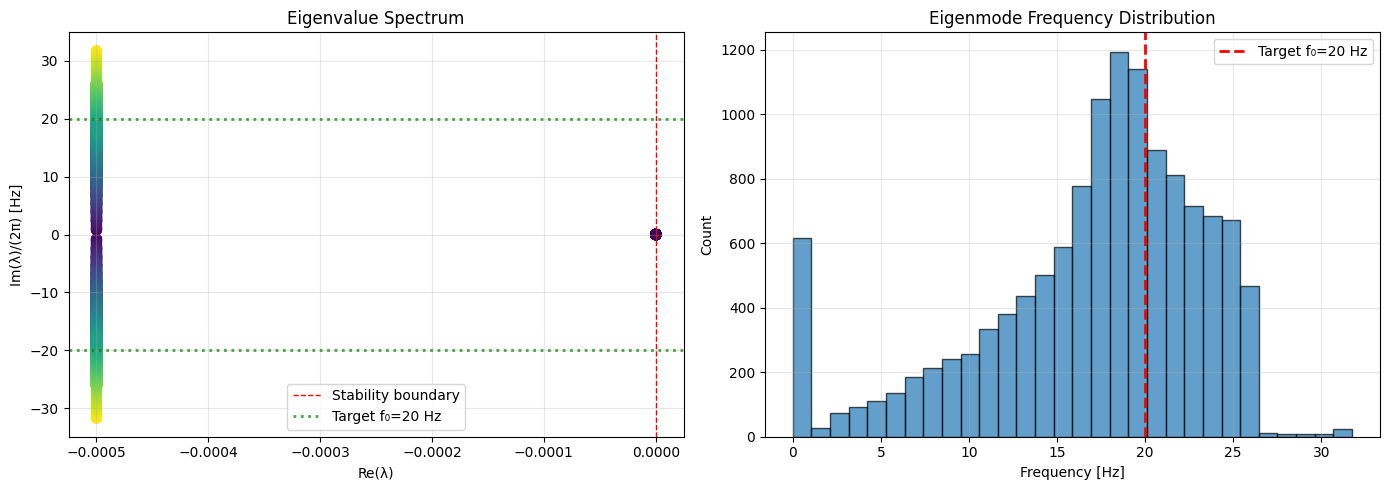

In [8]:
# Plot eigenvalue spectrum
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
freqs = eigenvalues.imag / (2 * np.pi)
ax1.scatter(eigenvalues.real, freqs, c=np.abs(eigenvalues), cmap='viridis', s=50, alpha=0.7)
ax1.axvline(x=0, color='r', linestyle='--', linewidth=1, label='Stability boundary')
ax1.axhline(y=f0, color='g', linestyle=':', linewidth=2, alpha=0.7, label=f'Target f₀={f0} Hz')
ax1.axhline(y=-f0, color='g', linestyle=':', linewidth=2, alpha=0.7)
ax1.set_xlabel('Re(λ)')
ax1.set_ylabel('Im(λ)/(2π) [Hz]')
ax1.set_title('Eigenvalue Spectrum')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.hist(np.abs(freqs), bins=30, edgecolor='black', alpha=0.7)
ax2.ticklabel_format(useOffset=False)
ax2.axvline(x=f0, color='r', linestyle='--', linewidth=2, label=f'Target f₀={f0} Hz')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Count')
ax2.set_title('Eigenmode Frequency Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Computing I/O coupling scores...

Capture 90% of total score:
  q = 4268

First drop > 0.5 decades:
  q = 6000, drop = 5.1 decades


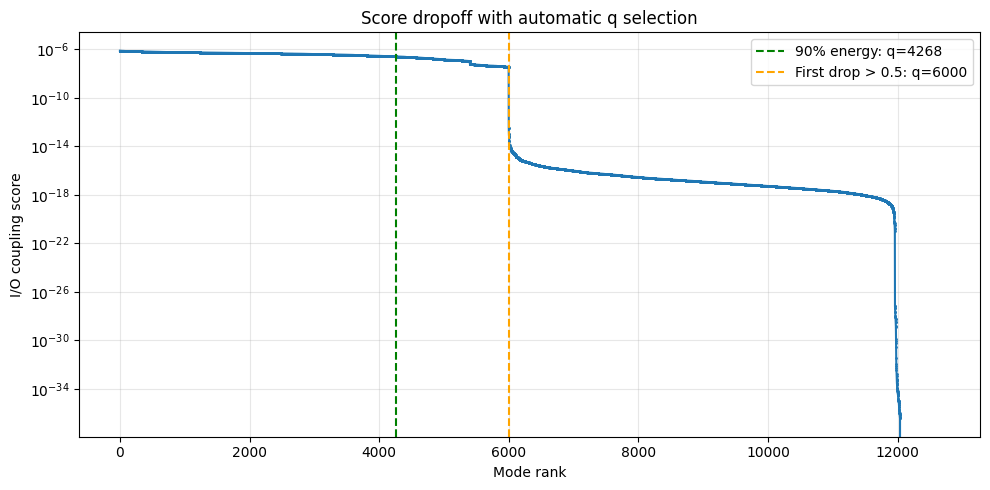

In [9]:
print("\nComputing I/O coupling scores...")

# Scores already use b_tilde and c_tilde computed above
scores = np.abs(b_tilde.flatten()) * np.linalg.norm(c_tilde, axis=0)

# Sort by score
idx_sorted = np.argsort(scores)[::-1]
scores_sorted = scores[idx_sorted]

cumsum = np.cumsum(scores_sorted)
total = cumsum[-1]
energy_pct = 0.90  # Capture __% of total coupling
q_energy = np.searchsorted(cumsum, energy_pct * total) + 1
print(f"\nCapture {100*energy_pct:.0f}% of total score:")
print(f"  q = {q_energy}")

log_scores = np.log10(scores_sorted + 1e-50)  # Avoid log(0)
diffs = np.diff(log_scores)  # Negative values = drops

# First significant drop (threshold in decades)
drop_threshold = 0.5  # adjust as needed
q_drop = np.argmax(-diffs > drop_threshold) + 1
if -diffs[q_drop - 1] <= drop_threshold:
    # No drop exceeds threshold, fall back to largest
    q_drop = np.argmin(diffs) + 1
drop_magnitude = -diffs[q_drop - 1]
print(f"\nFirst drop > {drop_threshold} decades:")
print(f"  q = {q_drop}, drop = {drop_magnitude:.1f} decades")

fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(scores_sorted, '.-', markersize=2)
ax.axvline(x=q_energy, color='g', linestyle='--', label=f'90% energy: q={q_energy}')
ax.axvline(x=q_drop, color='orange', linestyle='--', label=f'First drop > {drop_threshold}: q={q_drop}')
ax.set_xlabel('Mode rank')
ax.set_ylabel('I/O coupling score')
ax.set_title('Score dropoff with automatic q selection')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Build ROM

Select modes based on how strongly they couple input to output  -->  Score_i = ||b̃_i|| × ||c̃_i||

Then build ROM

- Aq = diag(λ_selected) — diagonal matrix with eigenvalues
- Bq = b̃[selected]
- Cq = c̃[:, selected]
- Vq = V[:, selected] — projection for state reconstruction


In [10]:
q = q_drop  # q_drop or q_energy
print(f"\nBuilding ROM with q = {q} modes...")

#q = 3500


Building ROM with q = 6000 modes...


In [11]:
# Select top q modes by I/O coupling
idx_selected = idx_sorted[:q]

# Extract components
lambda_q = eigenvalues[idx_selected]
V_q = V[:, idx_selected]           # (n × q) projection matrix

A_q = np.diag(lambda_q)            # (q × q) diagonal!
B_q = b_tilde[idx_selected, :]     # (q × 1)
C_q = c_tilde[:, idx_selected]     # (n_phones × q)

print(f"\n✓ ROM built:")
print(f"  Full dimension:    n = {n:,}")
print(f"  Reduced dimension: q = {q}")
print(f"  Compression:       {100*q/n:.2f}%")
print(f"\n  Aq: {A_q.shape} (diagonal)")
print(f"  Bq: {B_q.shape}")
print(f"  Cq: {C_q.shape}")
print(f"  Vq: {V_q.shape}")

# Stability guaranteed!
print(f"\n✓ Stability: max(Re(λ)) = {np.max(lambda_q.real):.2e}")


✓ ROM built:
  Full dimension:    n = 12,642
  Reduced dimension: q = 6000
  Compression:       47.46%

  Aq: (6000, 6000) (diagonal)
  Bq: (6000, 1)
  Cq: (5, 6000)
  Vq: (12642, 6000)

✓ Stability: max(Re(λ)) = -5.00e-04


Visualize selected frequencies

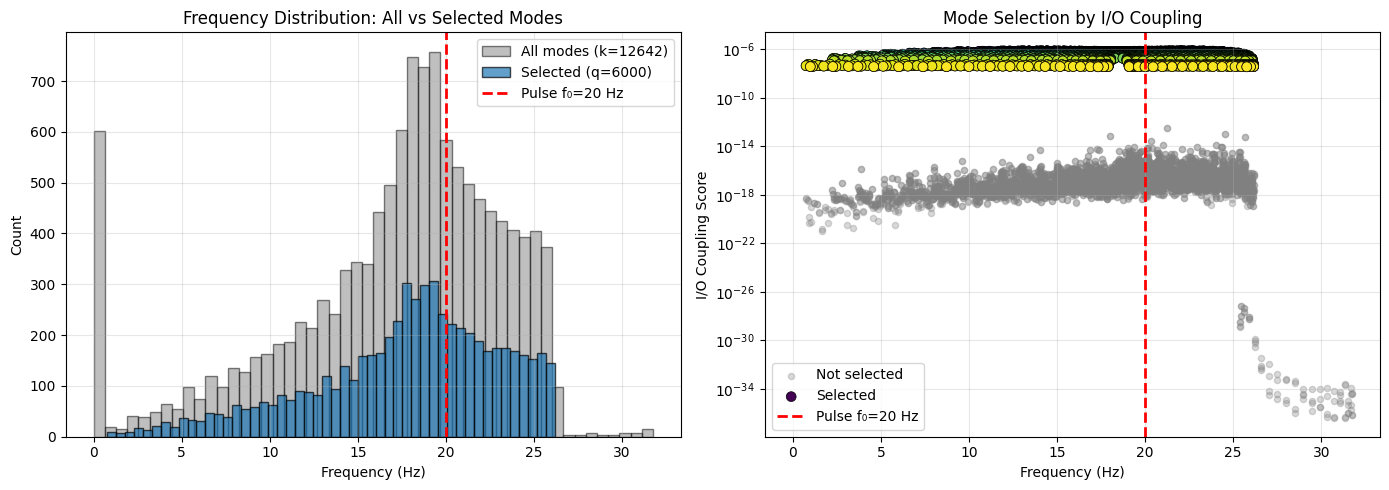


Selected frequency statistics:
  Min: 0.8 Hz
  Max: 26.2 Hz
  Mean: 17.7 Hz
  Median: 18.5 Hz
  Modes within ±10 Hz of pulse: 5390


In [12]:
# All eigenvalue frequencies
freqs_all = np.abs(eigenvalues.imag) / (2 * np.pi)

# Selected eigenvalue frequencies
freqs_selected = np.abs(lambda_q.imag) / (2 * np.pi)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram comparison
ax1 = axes[0]
ax1.hist(freqs_all, bins=50, alpha=0.5, label=f'All modes (k={k})', color='gray', edgecolor='black')
ax1.hist(freqs_selected, bins=50, alpha=0.7, label=f'Selected (q={q})', color='tab:blue', edgecolor='black')
ax1.axvline(x=f0, color='r', linestyle='--', linewidth=2, label=f'Pulse f₀={f0} Hz')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Count')
ax1.set_title('Frequency Distribution: All vs Selected Modes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Scatter showing selection by I/O coupling score
ax2 = axes[1]
scores_all = np.abs(b_tilde.flatten()) * np.linalg.norm(c_tilde, axis=0)

# Not selected (gray)
mask_not_selected = np.ones(k, dtype=bool)
mask_not_selected[idx_selected] = False
ax2.scatter(freqs_all[mask_not_selected], scores_all[mask_not_selected], 
            s=20, alpha=0.3, color='gray', label='Not selected')

# Selected (colored by rank)
ax2.scatter(freqs_selected, scores_all[idx_selected], 
            c=np.arange(q), s=50, cmap='viridis', edgecolors='black', linewidths=0.5, label='Selected')

ax2.axvline(x=f0, color='r', linestyle='--', linewidth=2, label=f'Pulse f₀={f0} Hz')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('I/O Coupling Score')
ax2.set_yscale('log')
ax2.set_title('Mode Selection by I/O Coupling')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Summary stats
print(f"\nSelected frequency statistics:")
print(f"  Min: {np.min(freqs_selected):.1f} Hz")
print(f"  Max: {np.max(freqs_selected):.1f} Hz")
print(f"  Mean: {np.mean(freqs_selected):.1f} Hz")
print(f"  Median: {np.median(freqs_selected):.1f} Hz")
print(f"  Modes within ±10 Hz of pulse: {np.sum(np.abs(freqs_selected - f0) <= 10)}")

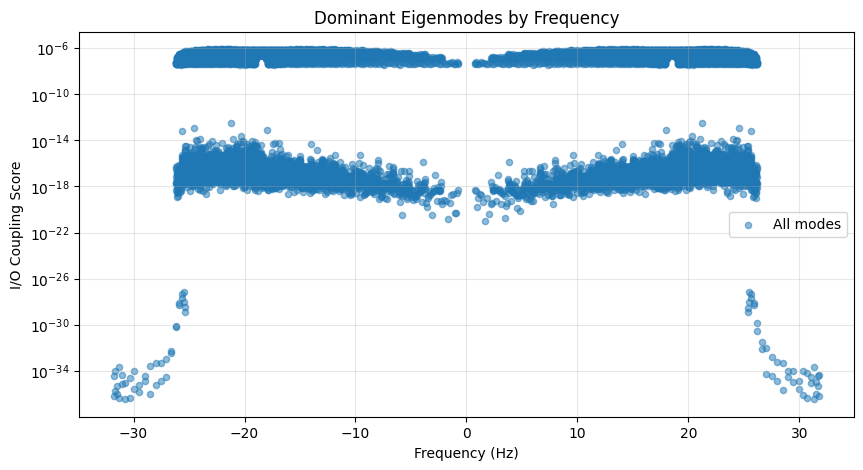

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(freqs, scores, s=20, alpha=0.5, label='All modes')
#ax.scatter(freqs[idx_sorted[:20]], scores[idx_sorted[:20]], 
           #s=100, c='red', edgecolors='black', label='Top 20')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('I/O Coupling Score')
ax.set_yscale('log')
ax.set_title('Dominant Eigenmodes by Frequency')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## Simulate ROM

Since Aq is diagonal, each mode is an independent scalar ODE:
# 
dx̃_i/dt = λ_i · x̃_i + Bq[i] · u(t)

In [14]:
def simulate_rom_exact(A_q, B_q, C_q, u_func, t_span, dt, x0=None):
    """
    Exact exponential integration for diagonal ROM.
    """
    q = A_q.shape[0]
    n_out = C_q.shape[0]
    
    t = np.arange(t_span[0], t_span[1] + dt, dt)
    n_steps = len(t)
    
    x_q = np.zeros((n_steps, q), dtype=complex)
    y = np.zeros((n_steps, n_out), dtype=complex)
    
    lam = np.diag(A_q)
    B_flat = B_q.flatten()
    
    exp_lam_dt = np.exp(lam * dt)
    with np.errstate(divide='ignore', invalid='ignore'):
        int_factor = np.where(
            np.abs(lam) > 1e-10,
            (exp_lam_dt - 1) / lam,
            dt * np.ones_like(lam)
        )
    
    # Initial condition
    if x0 is not None:
        xk = x0.flatten().astype(complex)
    else:
        xk = np.zeros(q, dtype=complex)
    
    for i in range(n_steps):
        x_q[i] = xk
        y[i] = C_q @ xk
        if i < n_steps - 1:
            uk = u_func(t[i])
            xk = exp_lam_dt * xk + int_factor * B_flat * uk
    
    return t, np.real(y), x_q


def simulate_rom_leapfrog(A_q, B_q, C_q, u_func, t_span, dt, x0=None):
    """
    Leapfrog for diagonal ROM - O(q) per step, not O(q²).
    """
    q = A_q.shape[0]
    n_out = C_q.shape[0]
    
    t = np.arange(t_span[0], t_span[1] + dt, dt)
    n_steps = len(t)
    
    x_q = np.zeros((n_steps, q), dtype=complex)
    y = np.zeros((n_steps, n_out), dtype=complex)
    
    lam = np.diag(A_q)
    B_flat = B_q.flatten()
    
    # Initial condition
    if x0 is not None:
        x_prev = x0.flatten().astype(complex)
        x_curr = x0.flatten().astype(complex)
    else:
        x_prev = np.zeros(q, dtype=complex)
        x_curr = np.zeros(q, dtype=complex)
    
    # Bootstrap with RK4
    u0 = u_func(t[0])
    k1 = lam * x_curr + B_flat * u0
    k2 = lam * (x_curr + 0.5*dt*k1) + B_flat * u_func(t[0] + 0.5*dt)
    k3 = lam * (x_curr + 0.5*dt*k2) + B_flat * u_func(t[0] + 0.5*dt)
    k4 = lam * (x_curr + dt*k3) + B_flat * u_func(t[0] + dt)
    x_next = x_curr + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    
    x_q[0] = x_curr
    y[0] = C_q @ x_curr
    x_prev = x_curr.copy()
    x_curr = x_next.copy()
    
    # Leapfrog loop
    for i in range(1, n_steps):
        x_q[i] = x_curr
        y[i] = C_q @ x_curr
        if i < n_steps - 1:
            u_i = u_func(t[i])
            f_i = lam * x_curr + B_flat * u_i
            x_next = x_prev + 2 * dt * f_i
            x_prev = x_curr.copy()
            x_curr = x_next.copy()
    
    return t, np.real(y), x_q

Running ROM simulation (q=6000, integrator=leapfrog)...
  Duration: 5333 ms
  Timestep: 589.3 μs
  Steps: 9,050

✓ ROM complete in 0.500s


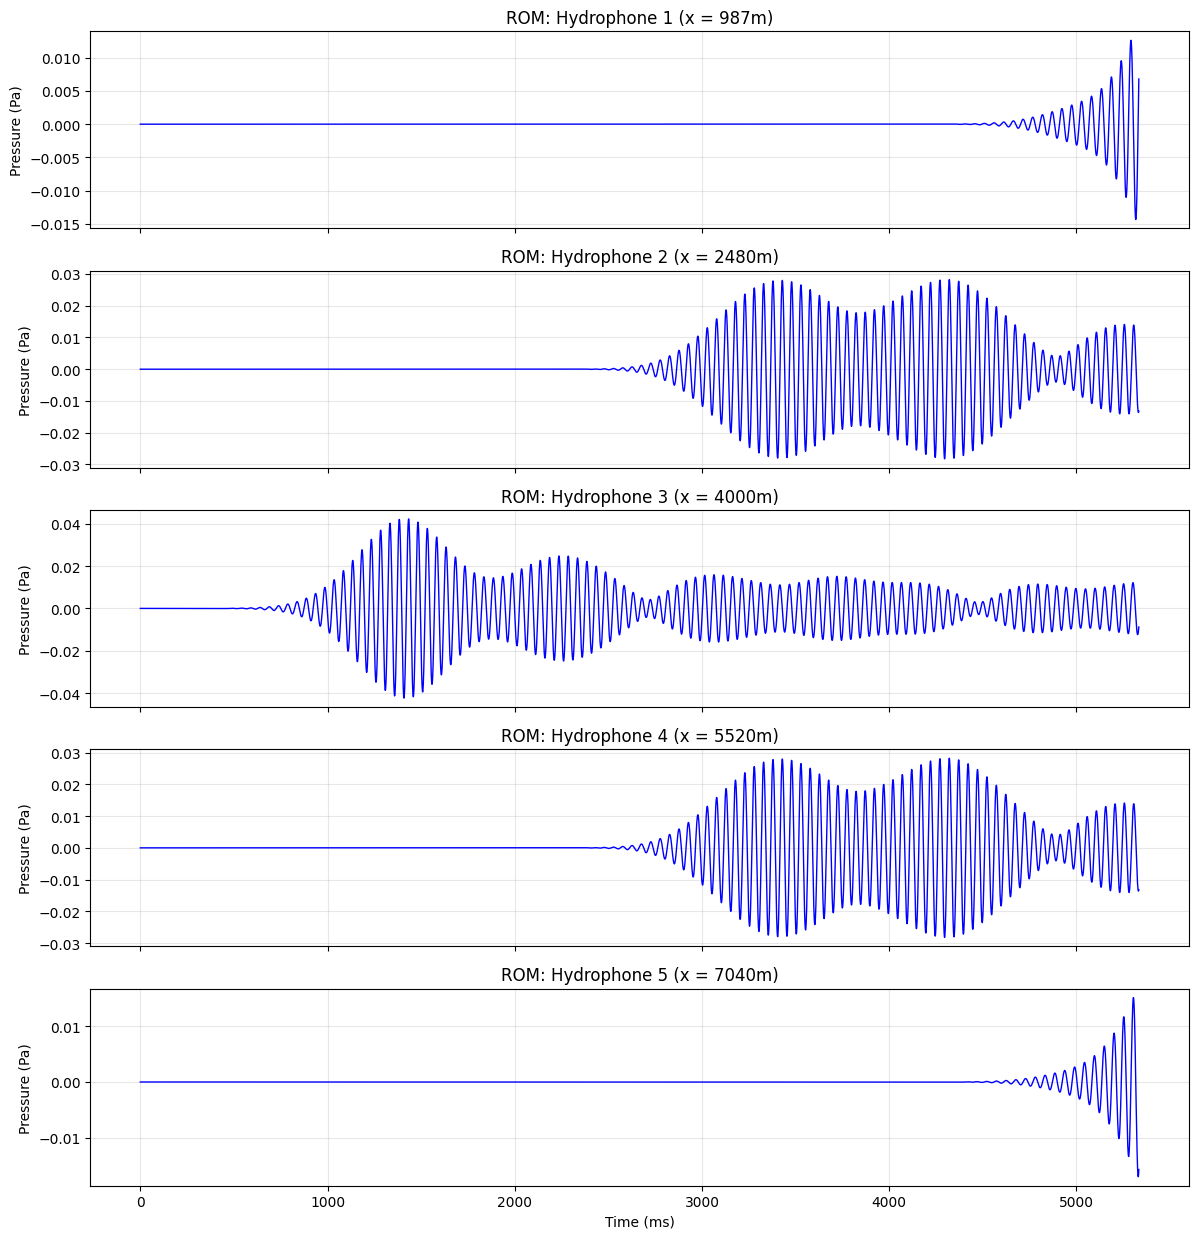

In [15]:
# Choose integrator: 'exact' or 'leapfrog'
ROM_INTEGRATOR = 'leapfrog'  # Use leapfrog to match full-order

# Timestep 
dt = max_dt_FE * 0.1

print(f"Running ROM simulation (q={q}, integrator={ROM_INTEGRATOR})...")
print(f"  Duration: {t_sim*1000:.0f} ms")
print(f"  Timestep: {dt*1e6:.1f} μs")
print(f"  Steps: {int(t_sim/dt):,}")

# Project full-order x_start to eigenspace
x0_full = x_start.flatten()

if FAST_TEST:
    # Dense: use V_inv
    x0_eigen_all = V_inv @ x0_full
else:
    # Sparse: use left eigenvectors W
    x0_eigen_all = np.conj(W.T) @ x0_full

# Select the q modes we're using
x0_eigen_q = x0_eigen_all[idx_selected]

t0 = time.perf_counter()

if ROM_INTEGRATOR == 'exact':
    t_rom, y_rom, x_rom = simulate_rom_exact(A_q, B_q, C_q, eval_u_scaled, (0, t_sim), dt, x0=x0_eigen_q)
else:
    t_rom, y_rom, x_rom = simulate_rom_leapfrog(A_q, B_q, C_q, eval_u_scaled, (0, t_sim), dt, x0=x0_eigen_q)

rom_time = time.perf_counter() - t0

print(f"\n✓ ROM complete in {rom_time:.3f}s")

# Plot ROM hydrophone responses
fig, axes = plt.subplots(n_phones, 1, figsize=(12, 2.5*n_phones), sharex=True)
if n_phones == 1:
    axes = [axes]

for i in range(n_phones):
    axes[i].plot(t_rom*1000, y_rom[:, i], 'b-', linewidth=1)
    axes[i].set_ylabel('Pressure (Pa)')
    axes[i].set_title(f'ROM: Hydrophone {i+1} (x = {h_x_indices[i]*p["dx"]:.0f}m)')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

## Full Order Reference
Run the full model with LeapfrogSolver for comparison

In [16]:
# Always run in FAST_TEST mode; optional in full mode
RUN_FULL_ORDER = True  # Set to False to skip in full mode

if RUN_FULL_ORDER:
    print(f"Running full-order simulation (n={n:,})...")
    if not FAST_TEST:
        print("⚠ This will take a while...")
    
    num_steps = int(np.ceil(t_sim / dt))
    
    t0 = time.perf_counter()
    X_ref, t_ref = LeapfrogSolver(
        eval_f_Sonar, 
        x_start, 
        p, 
        eval_u_scaled, 
        num_steps, 
        dt, 
        visualize=False,
        verbose=True
    )
    full_time = time.perf_counter() - t0
    
    # Extract hydrophone outputs using eval_g_Sonar
    print("Extracting hydrophone data...")
    y_ref = np.zeros((n_phones, len(t_ref)))
    for i in range(len(t_ref)):
        y_ref[:, i] = eval_g_Sonar(X_ref[:, i], p).flatten()
    
    print(f"\n✓ Full-order complete in {full_time:.1f}s")
    print(f"  SPEEDUP: {full_time/rom_time:.0f}x faster with ROM!")
else:
    t_ref, y_ref, full_time = None, None, None
    print("Skipping full-order simulation")

Running full-order simulation (n=12,642)...
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with RK4 for first step...
Running 9050 leapfrog steps...
  Progress: 10.0%
  Progress: 20.0%
  Progress: 30.0%
  Progress: 40.0%
  Progress: 50.0%
  Progress: 60.0%
  Progress: 70.0%
  Progress: 80.0%
  Progress: 90.0%
  Progress: 100.0%
Leapfrog integration complete!
Extracting hydrophone data...

✓ Full-order complete in 1.2s
  SPEEDUP: 2x faster with ROM!


## Compare

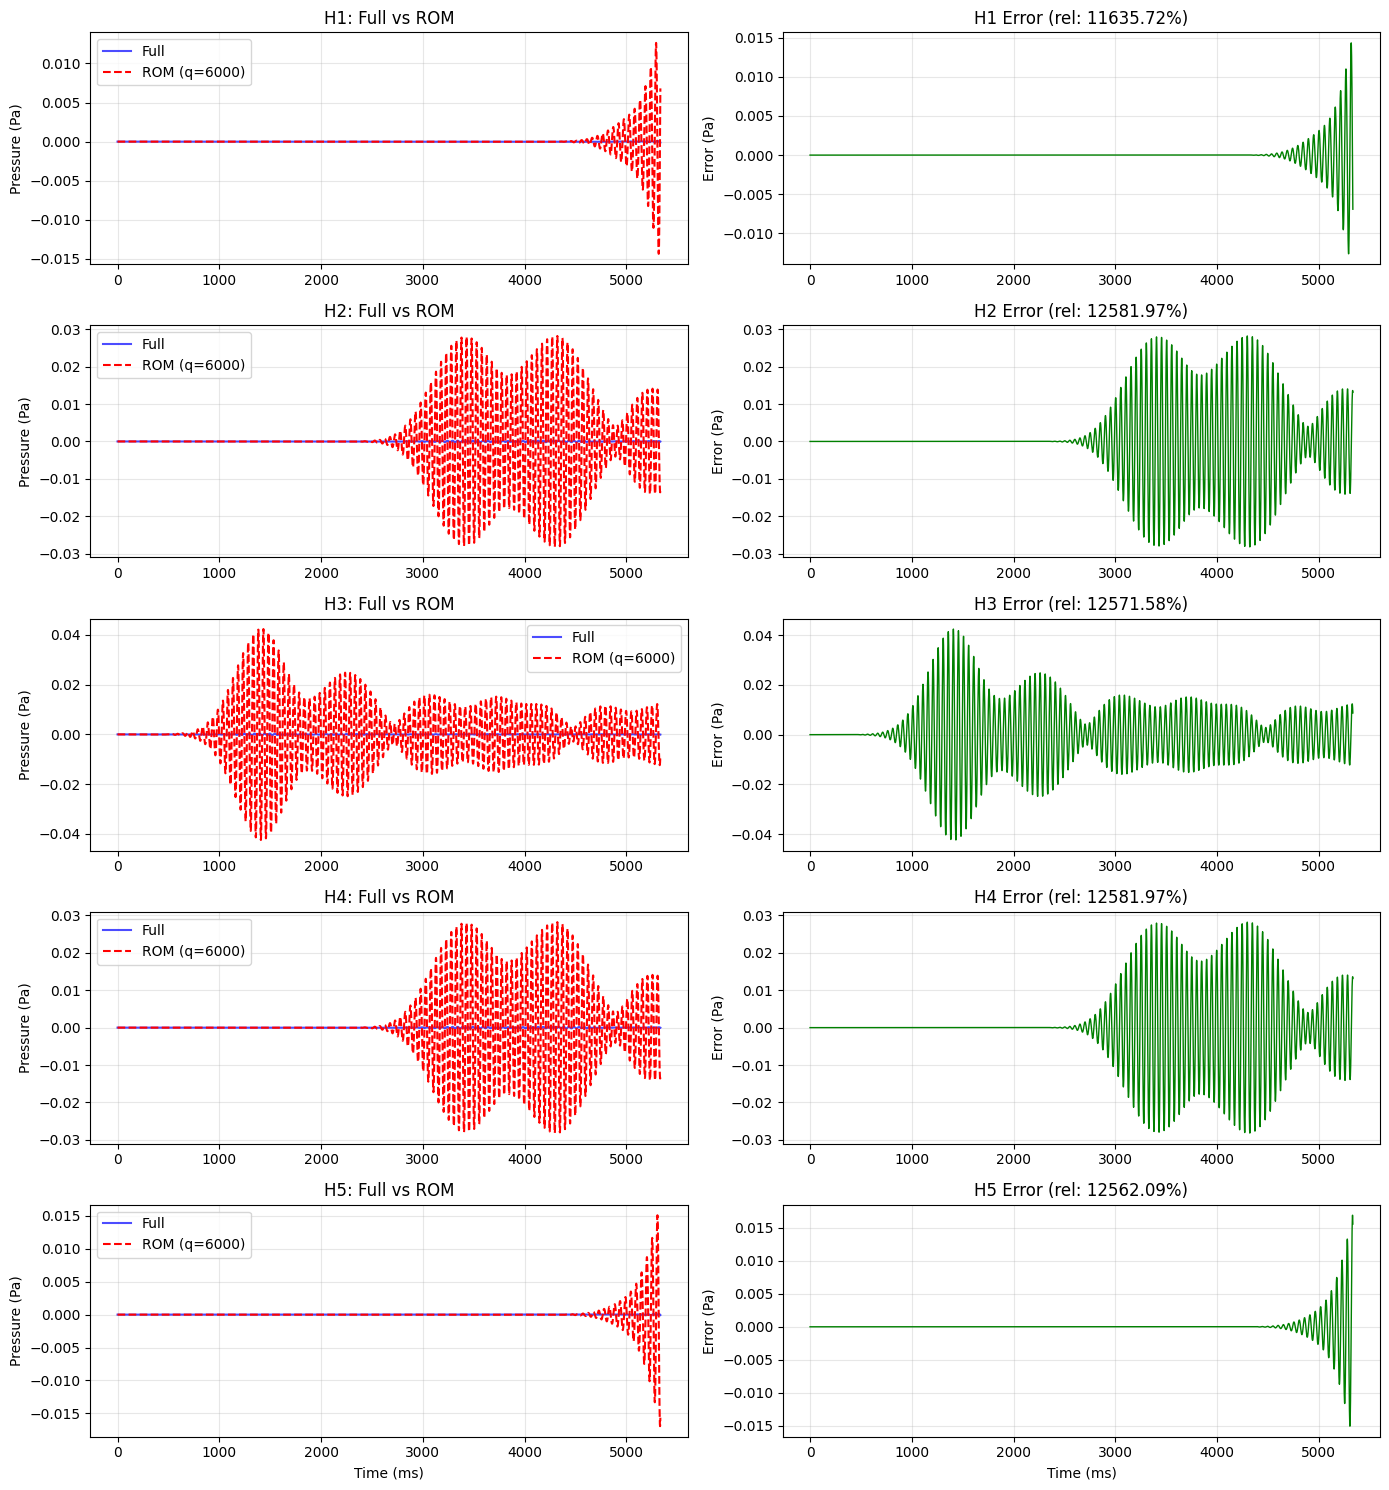

EIGENMODE ROM RESULTS
Full-order dimension:  n = 12,642
Reduced dimension:     q = 6000
Compression:           47.4608%

Accuracy (relative L2 error):
  Hydrophone 1: 11635.72%
  Hydrophone 2: 12581.97%
  Hydrophone 3: 12571.58%
  Hydrophone 4: 12581.97%
  Hydrophone 5: 12562.09%

Timing:
  Full-order: 1.2s
  ROM:        0.500s
  Speedup:    2x


In [17]:
if y_ref is not None:
    # Interpolate ROM to match reference time points
    from scipy.interpolate import interp1d
    
    errors = []
    
    fig, axes = plt.subplots(n_phones, 2, figsize=(14, 3*n_phones))
    if n_phones == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_phones):
        # Interpolate ROM output
        y_rom_interp = np.interp(t_ref, t_rom, y_rom[:, i])
        
        # Error
        err = y_ref[i, :] - y_rom_interp
        rel_err = np.linalg.norm(err) / (np.linalg.norm(y_ref[i, :]) + 1e-12)
        errors.append(rel_err)
        
        # Left: overlay
        axes[i, 0].plot(t_ref*1000, y_ref[i, :], 'b-', linewidth=1.5, label='Full', alpha=0.7)
        axes[i, 0].plot(t_rom*1000, y_rom[:, i], 'r--', linewidth=1.5, label=f'ROM (q={q})')
        axes[i, 0].set_ylabel('Pressure (Pa)')
        axes[i, 0].set_title(f'H{i+1}: Full vs ROM')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Right: error
        axes[i, 1].plot(t_ref*1000, err, 'g-', linewidth=1)
        axes[i, 1].set_ylabel('Error (Pa)')
        axes[i, 1].set_title(f'H{i+1} Error (rel: {100*rel_err:.2f}%)')
        axes[i, 1].grid(True, alpha=0.3)
    
    axes[-1, 0].set_xlabel('Time (ms)')
    axes[-1, 1].set_xlabel('Time (ms)')
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("=" * 60)
    print("EIGENMODE ROM RESULTS")
    print("=" * 60)
    print(f"Full-order dimension:  n = {n:,}")
    print(f"Reduced dimension:     q = {q}")
    print(f"Compression:           {100*q/n:.4f}%")
    print(f"\nAccuracy (relative L2 error):")
    for i, err in enumerate(errors):
        print(f"  Hydrophone {i+1}: {100*err:.2f}%")
    print(f"\nTiming:")
    print(f"  Full-order: {full_time:.1f}s")
    print(f"  ROM:        {rom_time:.3f}s")
    print(f"  Speedup:    {full_time/rom_time:.0f}x")
    print("=" * 60)

## Convergence study 
Vary q

Convergence study...
  q= 100: error=8611.05%, time=0.0339s, speedup=35.3x
  q= 500: error=28768.45%, time=0.0775s, speedup=15.4x
  q=1000: error=31913.73%, time=0.1288s, speedup=9.3x
  q=1500: error=28179.30%, time=0.1659s, speedup=7.2x
  q=2000: error=22806.76%, time=0.2458s, speedup=4.9x
  q=3000: error=21377.59%, time=0.3640s, speedup=3.3x
  q=4000: error=13359.06%, time=0.5477s, speedup=2.2x
  q=4268: error=12233.40%, time=0.7523s, speedup=1.6x
  q=5000: error=12288.70%, time=0.5063s, speedup=2.4x
  q=6000: error=11635.72%, time=0.6060s, speedup=2.0x
  q=7000: error=11635.72%, time=0.6643s, speedup=1.8x
  q=8000: error=11635.72%, time=0.7290s, speedup=1.6x
  q=9000: error=11635.72%, time=0.8261s, speedup=1.4x
  q=10000: error=11635.72%, time=1.0428s, speedup=1.1x


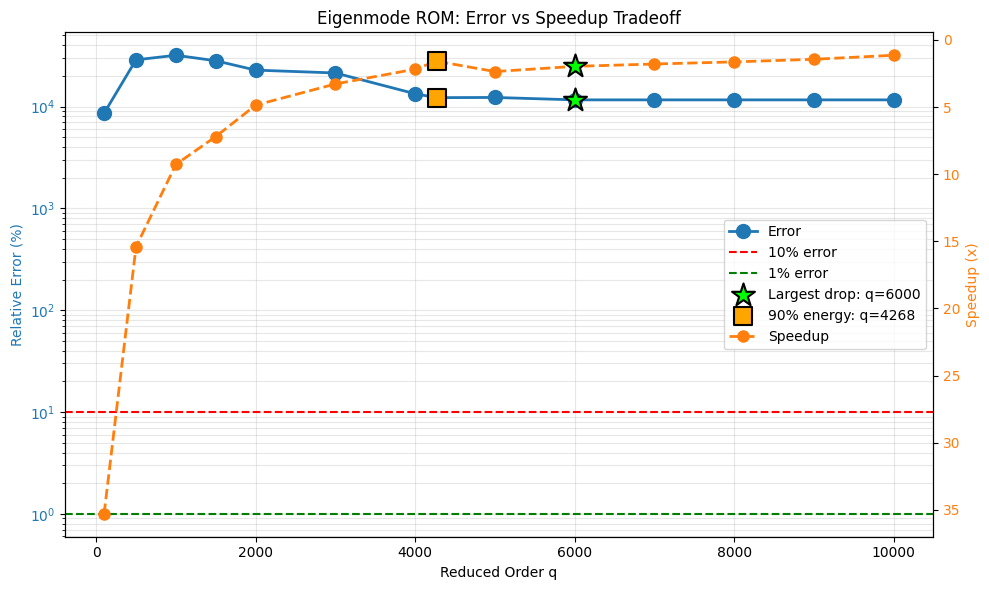

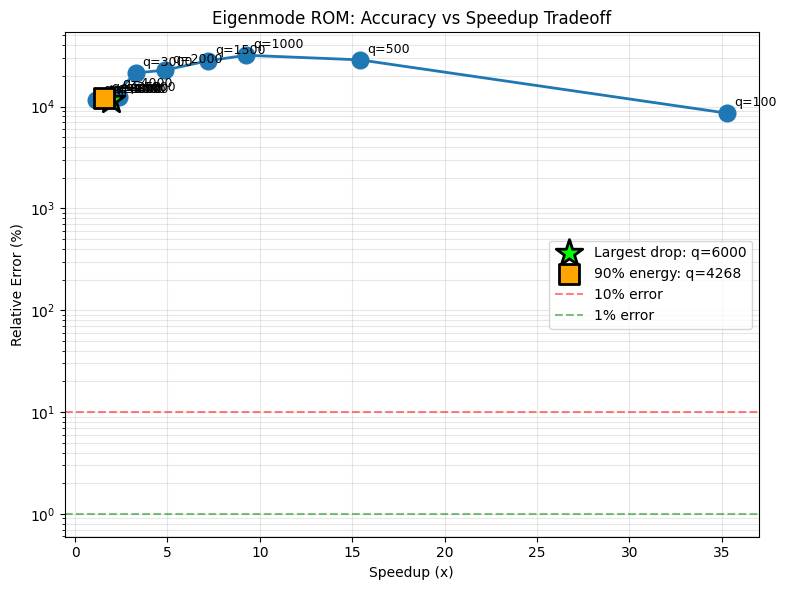


EIGENMODE TRUNCATION MOR - COMPLETE
Method: Dominant poles with I/O coupling selection
Key advantage: Diagonal Aq preserves stability


In [18]:
if y_ref is not None:
    q_values = [100, 500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    q_values = q_values + [q_energy, q_drop] 
    q_values = sorted(list(set(q_values)))  # Unique and sorted
    q_values = [qv for qv in q_values if qv <= k]  # Can't exceed computed modes
    
    print("Convergence study...")
    results = []
    
    for q_test in q_values:
        idx_sel = idx_sorted[:q_test]
        
        A_test = np.diag(eigenvalues[idx_sel])
        B_test = b_tilde[idx_sel, :]
        C_test = c_tilde[:, idx_sel]
        
        t0_s = time.perf_counter()
        _, y_test, _ = simulate_rom_leapfrog(A_test, B_test, C_test, eval_u_scaled, (0, t_sim), dt)
        sim_t = time.perf_counter() - t0_s
        
        # Error on first hydrophone
        y_interp = np.interp(t_ref, t_rom, y_test[:, 0])
        rel_err = np.linalg.norm(y_ref[0, :] - y_interp) / (np.linalg.norm(y_ref[0, :]) + 1e-12)
        
        speedup = full_time / sim_t if sim_t > 0 else 0
        
        results.append({'q': q_test, 'error': rel_err, 'time': sim_t, 'speedup': speedup})
        print(f"  q={q_test:4d}: error={100*rel_err:6.2f}%, time={sim_t:.4f}s, speedup={speedup:.1f}x")
    
    # Extract data
    qs = [r['q'] for r in results]
    errs = [100*r['error'] for r in results]
    speedups = [r['speedup'] for r in results]
    
    # Find indices for special points
    idx_energy = qs.index(q_energy) if q_energy in qs else None
    idx_drop = qs.index(q_drop) if q_drop in qs else None
    
    # ================================================================
    # PLOT 1: Error and Speedup vs q (dual y-axes)
    # ================================================================
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Left axis: Error (log scale)
    color1 = 'tab:blue'
    ax1.set_xlabel('Reduced Order q')
    ax1.set_ylabel('Relative Error (%)', color=color1)
    ax1.semilogy(qs, errs, 'o-', color=color1, linewidth=2, markersize=10, label='Error')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.axhline(y=10, color='r', linestyle='--', alpha=1, label='10% error')
    ax1.axhline(y=1, color='g', linestyle='--', alpha=1, label='1% error')
    
    # Highlight q_drop (green star) and q_energy (orange square) on error axis
    if idx_drop is not None:
        ax1.scatter([qs[idx_drop]], [errs[idx_drop]], marker='*', s=300, 
                    color='lime', edgecolors='black', linewidths=1.5, zorder=5, 
                    label=f'Largest drop: q={q_drop}')
    if idx_energy is not None:
        ax1.scatter([qs[idx_energy]], [errs[idx_energy]], marker='s', s=150, 
                    color='orange', edgecolors='black', linewidths=1.5, zorder=5, 
                    label=f'90% energy: q={q_energy}')
    
    # Right axis: Speedup (inverted)
    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel('Speedup (x)', color=color2)
    ax2.plot(qs, speedups, 'o--', color=color2, linewidth=2, markersize=8, label='Speedup')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.invert_yaxis()
    
    # Highlight q_drop (green star) and q_energy (orange square) on speedup axis
    if idx_drop is not None:
        ax2.scatter([qs[idx_drop]], [speedups[idx_drop]], marker='*', s=300, 
                    color='lime', edgecolors='black', linewidths=1.5, zorder=5)
    if idx_energy is not None:
        ax2.scatter([qs[idx_energy]], [speedups[idx_energy]], marker='s', s=150, 
                    color='orange', edgecolors='black', linewidths=1.5, zorder=5)
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    
    ax1.set_title('Eigenmode ROM: Error vs Speedup Tradeoff')
    ax1.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()
    
    # ================================================================
    # PLOT 2: Error vs Speedup (Pareto)
    # ================================================================
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.semilogy(speedups, errs, 'o-', linewidth=2, markersize=12, color='tab:blue')
    
    # Label each point with q value
    for i, q_val in enumerate(qs):
        ax.annotate(f'q={q_val}', (speedups[i], errs[i]), 
                    textcoords='offset points', xytext=(5, 5), fontsize=9)
    
    # Highlight q_drop (green star) and q_energy (orange square)
    if idx_drop is not None:
        ax.scatter([speedups[idx_drop]], [errs[idx_drop]], marker='*', s=400, 
                   color='lime', edgecolors='black', linewidths=2, zorder=5, 
                   label=f'Largest drop: q={q_drop}')
    if idx_energy is not None:
        ax.scatter([speedups[idx_energy]], [errs[idx_energy]], marker='s', s=200, 
                   color='orange', edgecolors='black', linewidths=2, zorder=5, 
                   label=f'90% energy: q={q_energy}')
    
    # Reference lines
    ax.axhline(y=10, color='r', linestyle='--', alpha=0.5, label='10% error')
    ax.axhline(y=1, color='g', linestyle='--', alpha=0.5, label='1% error')
    
    ax.set_xlabel('Speedup (x)')
    ax.set_ylabel('Relative Error (%)')
    ax.set_title('Eigenmode ROM: Accuracy vs Speedup Tradeoff')
    ax.legend()
    ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("EIGENMODE TRUNCATION MOR - COMPLETE")
print("="*60)
print(f"Method: Dominant poles with I/O coupling selection")
print(f"Key advantage: Diagonal Aq preserves stability")
print("="*60)

Visualize

## Diagnostics

In [19]:
# 1. Check that V * V⁻¹ = I
V_inv = np.linalg.inv(V)
identity_error = np.linalg.norm(V @ V_inv - np.eye(n)) / n
print(f"1. V @ V⁻¹ ≈ I? Error: {identity_error:.2e}")

# 2. Check that V⁻¹ @ A @ V = diag(λ)
Lambda_reconstructed = V_inv @ A_dense @ V
off_diag = Lambda_reconstructed - np.diag(np.diag(Lambda_reconstructed))
off_diag_error = np.linalg.norm(off_diag) / np.linalg.norm(Lambda_reconstructed)
print(f"2. V⁻¹AV diagonal? Off-diag error: {off_diag_error:.2e}")

# 3. Check initial conditions match
x0_full = x_start.flatten()
print(f"3. Initial condition:")
print(f"   Full-order x0 norm: {np.linalg.norm(x0_full):.2e}")
print(f"   ROM starts at zero")

# 4. Check time arrays match
print(f"4. Time arrays:")
print(f"   t_rom: {len(t_rom)} points, [{t_rom[0]:.4f}, {t_rom[-1]:.4f}]")
print(f"   t_ref: {len(t_ref)} points, [{t_ref[0]:.4f}, {t_ref[-1]:.4f}]")

# 5. Compare at first few timesteps (Hydrophone 1)
print(f"\n5. First few timesteps (H1):")
for i in range(min(5, len(t_rom))):
    y_full_i = y_ref[0, i]
    y_rom_i = y_rom[i, 0]
    print(f"   t={t_rom[i]*1000:.3f}ms: full={y_full_i:.4e}, rom={y_rom_i:.4e}")

1. V @ V⁻¹ ≈ I? Error: 8.31e-15
2. V⁻¹AV diagonal? Off-diag error: 3.04e-12
3. Initial condition:
   Full-order x0 norm: 0.00e+00
   ROM starts at zero
4. Time arrays:
   t_rom: 9052 points, [0.0000, 5.3334]
   t_ref: 9052 points, [0.0000, 5.3334]

5. First few timesteps (H1):
   t=0.000ms: full=0.0000e+00, rom=0.0000e+00
   t=0.589ms: full=0.0000e+00, rom=3.3232e-18
   t=1.179ms: full=0.0000e+00, rom=1.3247e-17
   t=1.768ms: full=0.0000e+00, rom=2.9508e-17
   t=2.357ms: full=0.0000e+00, rom=5.2003e-17


In [20]:
scores = np.abs(b_tilde.flatten()) * np.linalg.norm(c_tilde, axis=0)
freqs_modes = np.abs(eigenvalues.imag) / (2 * np.pi)

# Top 10 modes
idx_top = np.argsort(scores)[::-1][:10]
print("Top 10 modes by I/O coupling:")
print(f"{'Rank':<5} {'Freq (Hz)':<12} {'|b̃|':<12} {'||c̃||':<12} {'Score':<12}")
print("-" * 55)
for rank, idx in enumerate(idx_top):
    b_mag = np.abs(b_tilde[idx, 0])
    c_mag = np.linalg.norm(c_tilde[:, idx])
    print(f"{rank+1:<5} {freqs_modes[idx]:<12.1f} {b_mag:<12.2e} {c_mag:<12.2e} {scores[idx]:<12.2e}")

Top 10 modes by I/O coupling:
Rank  Freq (Hz)    |b̃|         ||c̃||       Score       
-------------------------------------------------------
1     22.7         1.98e-05     3.97e-02     7.86e-07    
2     22.7         1.98e-05     3.97e-02     7.86e-07    
3     22.0         1.98e-05     3.97e-02     7.86e-07    
4     22.0         1.98e-05     3.97e-02     7.86e-07    
5     21.8         1.98e-05     3.93e-02     7.79e-07    
6     21.8         1.98e-05     3.93e-02     7.79e-07    
7     22.5         1.98e-05     3.93e-02     7.79e-07    
8     22.5         1.98e-05     3.93e-02     7.79e-07    
9     13.4         1.98e-05     3.94e-02     7.79e-07    
10    13.4         1.98e-05     3.94e-02     7.79e-07    
